In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt

In [2]:
df = pd.read_excel('imputed_temperature_columns_by_day_poly_lasso_cv.xlsx')
df = df.dropna(subset=['Dissolved_Phosphorus'])
df = df.reset_index(drop=True)
y_dis = df['Dissolved_Phosphorus']
y_tot = df['Total_Phosphorus']
X = df.drop(['Dissolved_Phosphorus', 'Total_Phosphorus'], axis=1)
X = X.drop(['date'], axis=1)
X = X.to_numpy()
y_dis = y_dis.to_numpy()
random_state = 43
test_size = 0.2
X_train_dis, X_test_dis, y_train_dis, y_test_dis = train_test_split(X, y_dis, test_size=test_size, random_state=random_state)
X_train_tot, X_test_tot, y_train_tot, y_test_tot = train_test_split(X, y_tot, test_size=test_size, random_state=random_state)

params = dict()
params["device"] = "cuda" # Use GPU for training
params["tree_method"] = "hist"
params["max_depth"] = 15
params["lambda"] = 10
params["alpha"] = 0
params["eta"] = 0.3
params["gamma"] = 0
params["min_child_weight"] = 1
params["grow_policy"] = "depthwise"
params["max_bin"] = 256
params["subsample"] = 0.2
params["num_parallel_tree"] = 5
params["colsample_bytree"] = 0.5
params["colsample_bylevel"] = 0.5
params["colsample_bynode"] = 0.5

# Build boosted trees
bst_dis = xgb.train(params=params, dtrain=xgb.DMatrix(X_train_dis, label=y_train_dis), num_boost_round=50)
bst_tot = xgb.train(params=params, dtrain=xgb.DMatrix(X_train_tot, label=y_train_tot), num_boost_round=50)

# Form test data matrix
dtest_dis = xgb.DMatrix(X_test_dis)
dtest_tot = xgb.DMatrix(X_test_tot)
# Predict using the test data matrix
y_pred_dis = bst_dis.predict(dtest_dis)
y_pred_tot = bst_tot.predict(dtest_tot)
# Calculate error
error_dis = y_test_dis - y_pred_dis
error_tot = y_test_tot - y_pred_tot
print("Dissolved Phosphorus Mean Absolute Error (ug/L): ", np.mean(np.abs(error_dis)))
print("Dissolved Phosphorus Mean Squared Error (ug/L): ", mean_squared_error(y_test_dis, y_pred_dis))
print("Total Phosphorus Mean Absolute Error (ug/L): ", np.mean(np.abs(error_tot)))
print("Total Phosphorus Mean Squared Error (ug/L): ", mean_squared_error(y_test_tot, y_pred_tot))

Dissolved Phosphorus Mean Absolute Error (ug/L):  18.45619564251657
Dissolved Phosphorus Mean Squared Error (ug/L):  682.9131996045512
Total Phosphorus Mean Absolute Error (ug/L):  45.81330062571342
Total Phosphorus Mean Squared Error (ug/L):  3732.4007502689365


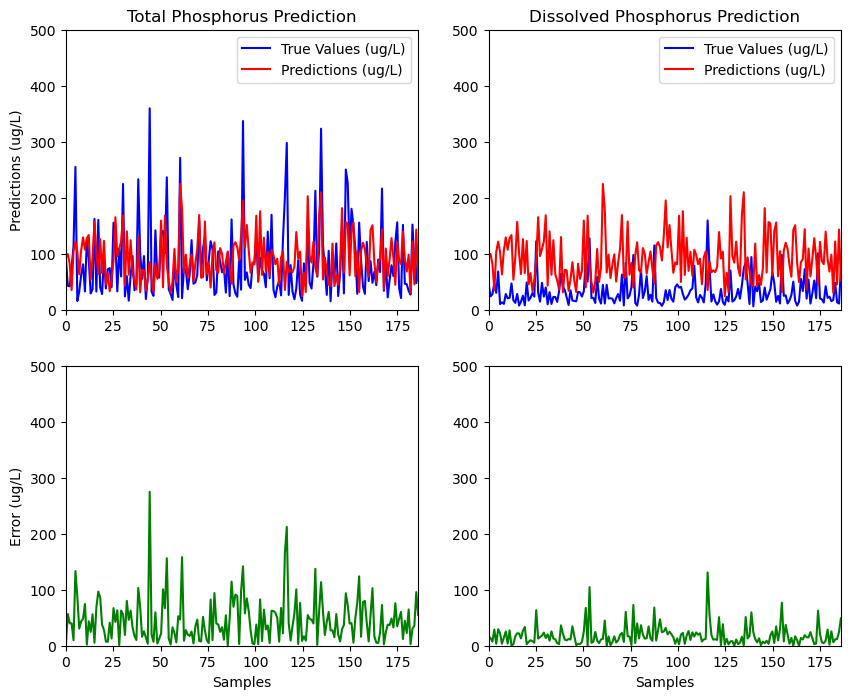

In [3]:
# X-axis for plotting
x_plot = np.linspace(0,y_test_dis.shape[0],y_test_dis.shape[0])
# Plotting
xlim = 186
plt.figure(figsize=(10, 8))
plt.subplot(2, 2, 1)
plt.plot(x_plot, y_test_tot, color='blue', label='True Values (ug/L)')
plt.plot(x_plot, y_pred_tot, color='red', label='Predictions (ug/L)')
plt.legend()
plt.ylabel('Predictions (ug/L)')
plt.title('Total Phosphorus Prediction')
plt.ylim(0, 500)
plt.xlim(0, xlim)
plt.subplot(2, 2, 3)
plt.plot(x_plot, abs(error_tot), color='green')
plt.xlabel("Samples")
plt.ylabel('Error (ug/L)')
plt.ylim(0, 500)
plt.xlim(0, xlim)
plt.subplot(2, 2, 2)
plt.plot(x_plot, y_test_dis, color='blue', label='True Values (ug/L)')
plt.plot(x_plot, y_pred_tot, color='red', label='Predictions (ug/L)')
plt.legend()
plt.title('Dissolved Phosphorus Prediction')
plt.ylim(0, 500)
plt.xlim(0, xlim)
plt.subplot(2, 2, 4)
plt.plot(x_plot, abs(error_dis), color='green')
plt.xlabel("Samples")
plt.ylim(0, 500)
plt.xlim(0, xlim)
#plt.show()
plt.savefig('xgboost_predictions.png', dpi=300, bbox_inches='tight')